# Teste de crop horizontal após rotação e limiar

## Importando bibliotecas

In [1]:
import numpy as np
import seaborn as sns

from zipfile import ZipFile
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import rotate

from img_edit import (auto_rotate,
                      fill_empty_edges,
                      best_rgb,
                      rgb_to_color,
                      crop_horizontal)

sns.set_style(style='darkgrid')
plt.gray()

LIMITE_DE_NORMALIZACAO = 8

COLOR_NAMES = ['vermelho', 'verde', 'azul']
COLOR_CODES = ['r-', 'g-', 'b-', 'brown-', 'orange-']

<Figure size 432x288 with 0 Axes>

In [2]:
path_list = []
with ZipFile('./toras.zip') as zip_file:
  for path in zip_file.namelist():
    if '__MAC' not in path \
        and '.JPG' in path:
      path_list.append(f'./toras.zip/{path}')

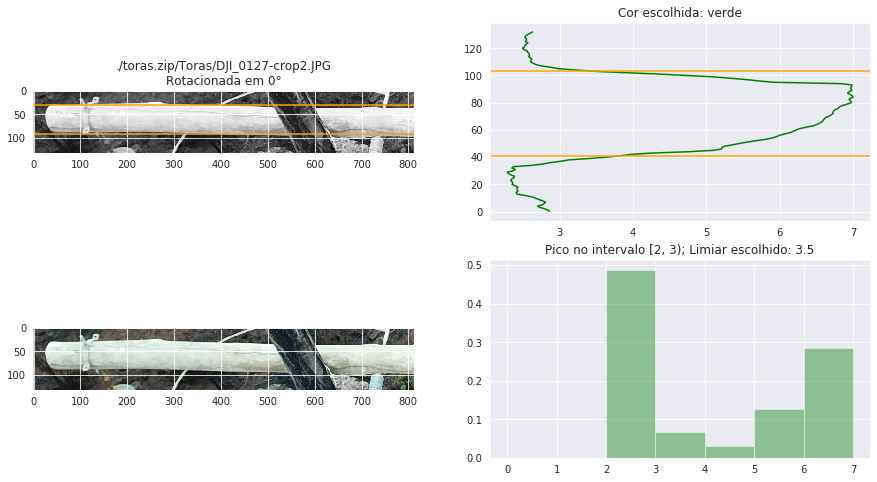

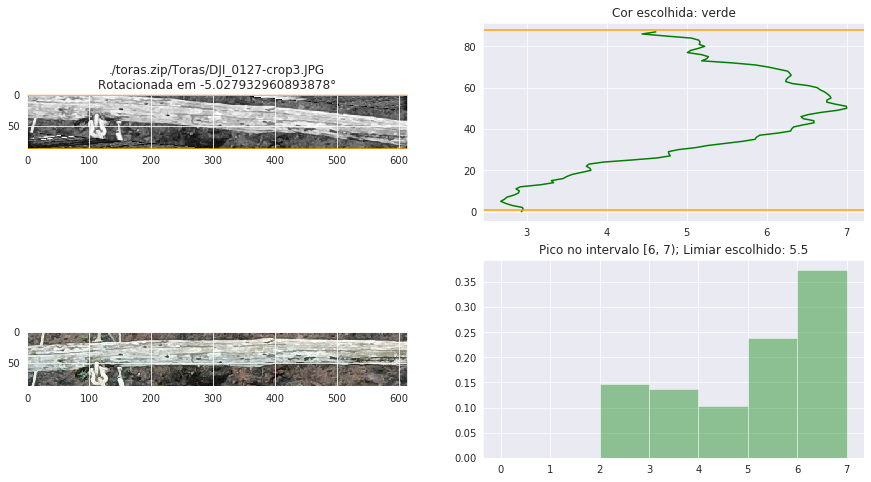

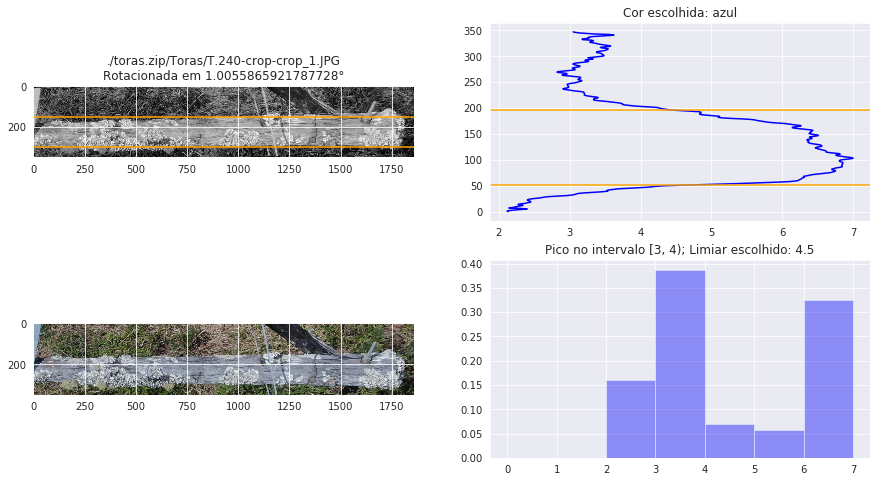

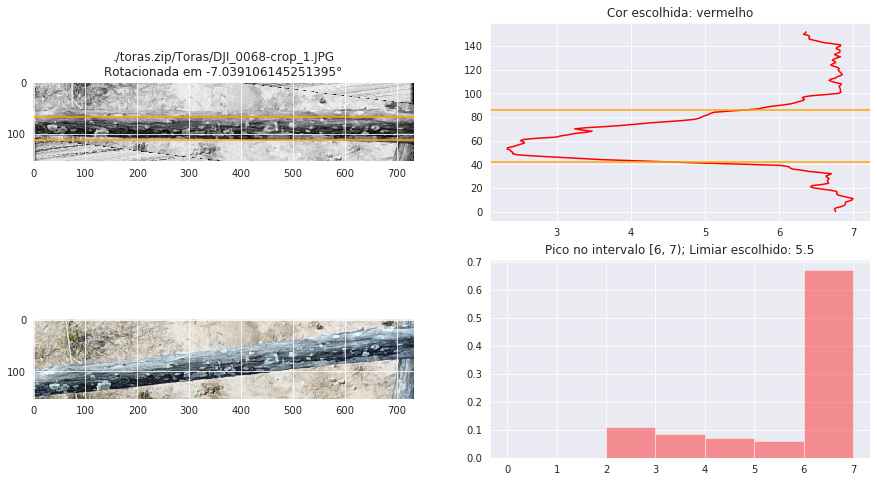

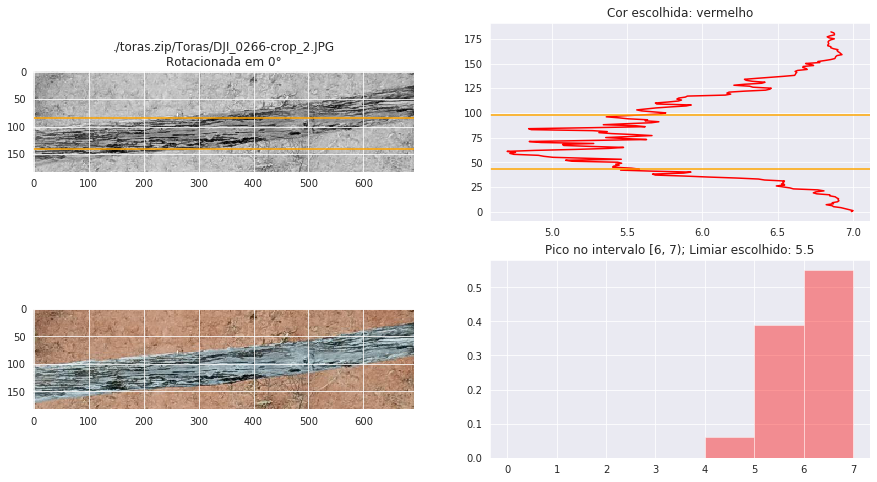

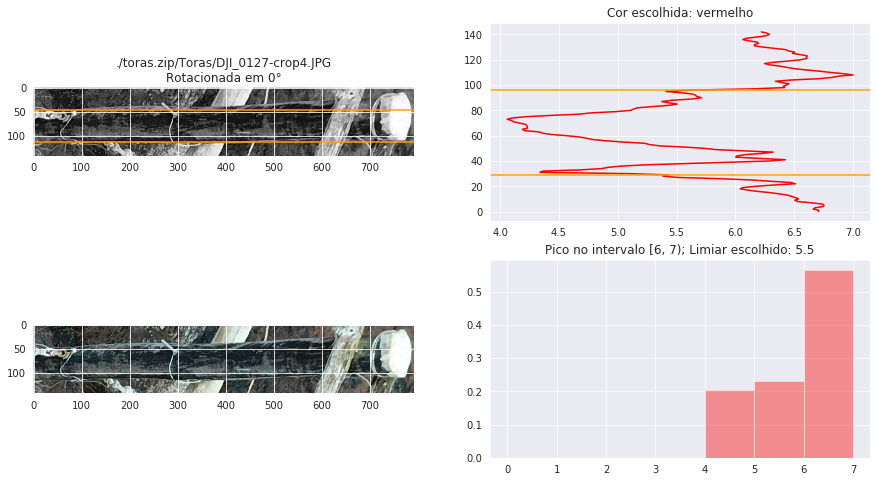

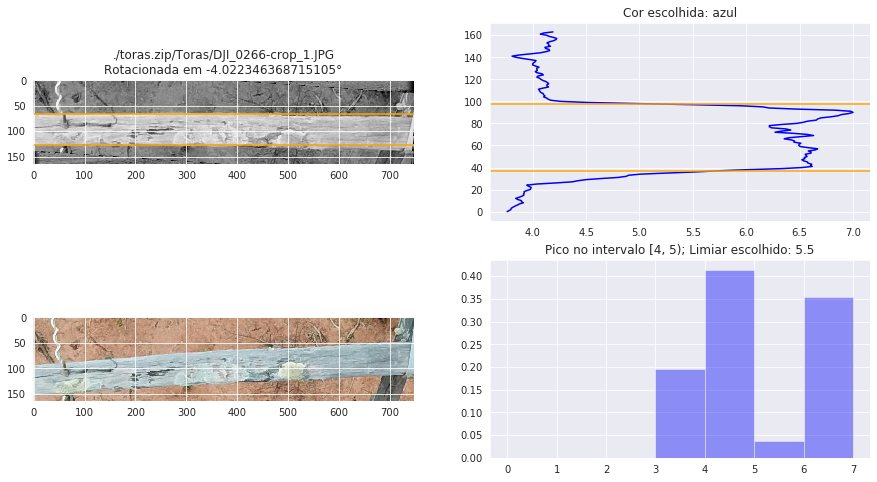

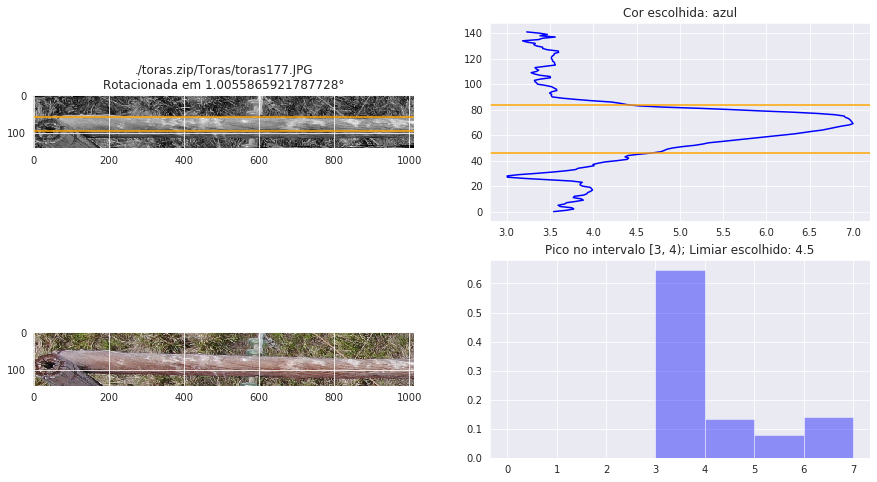

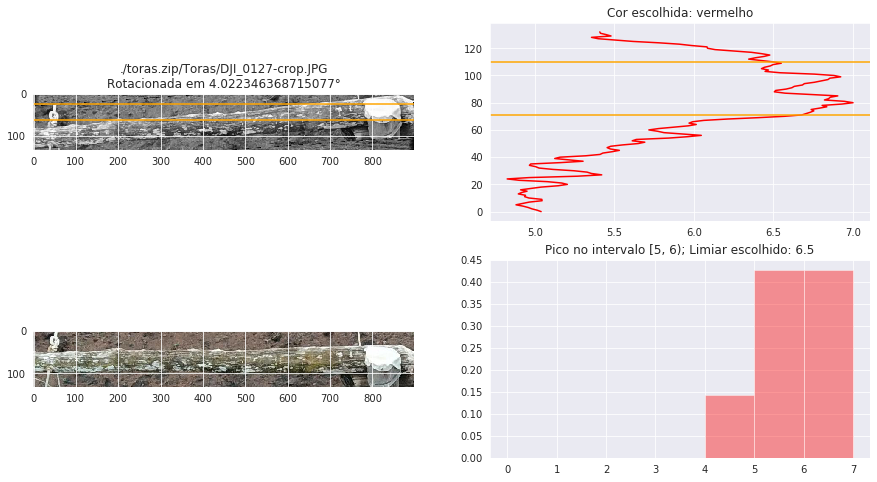

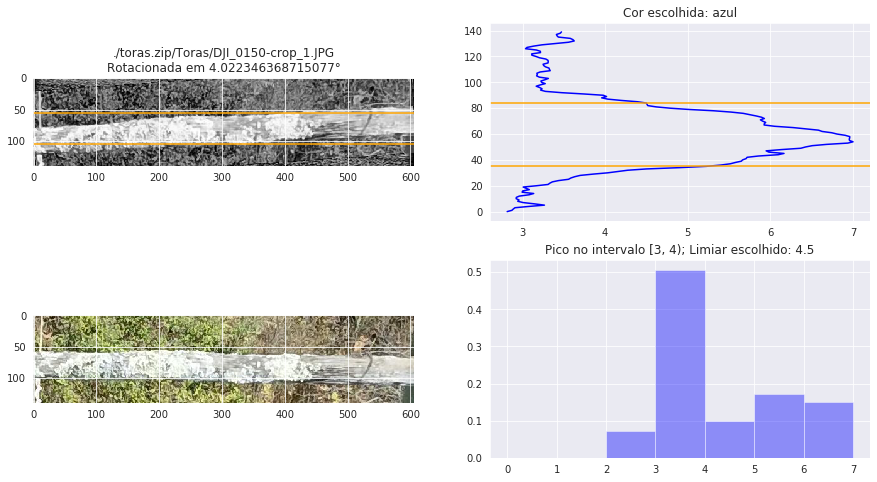

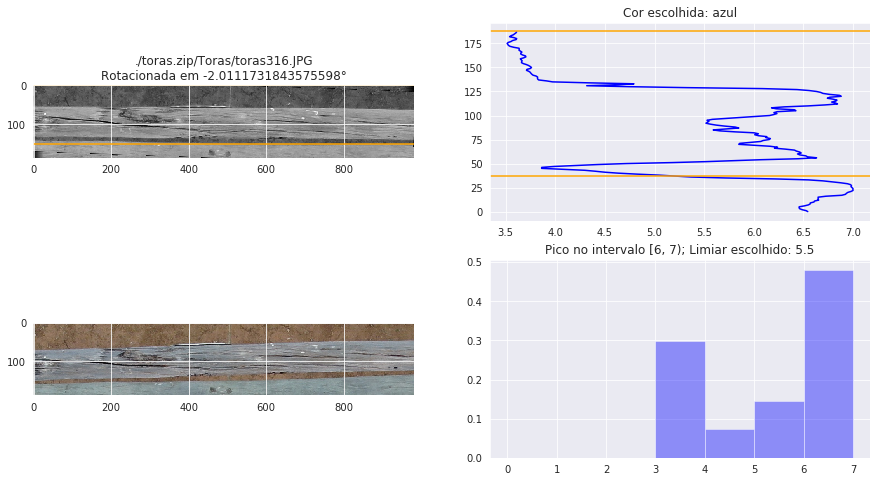

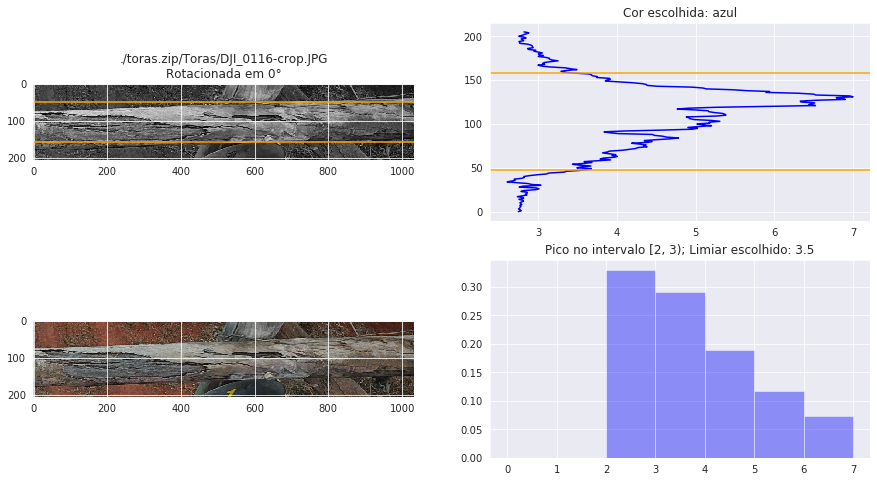

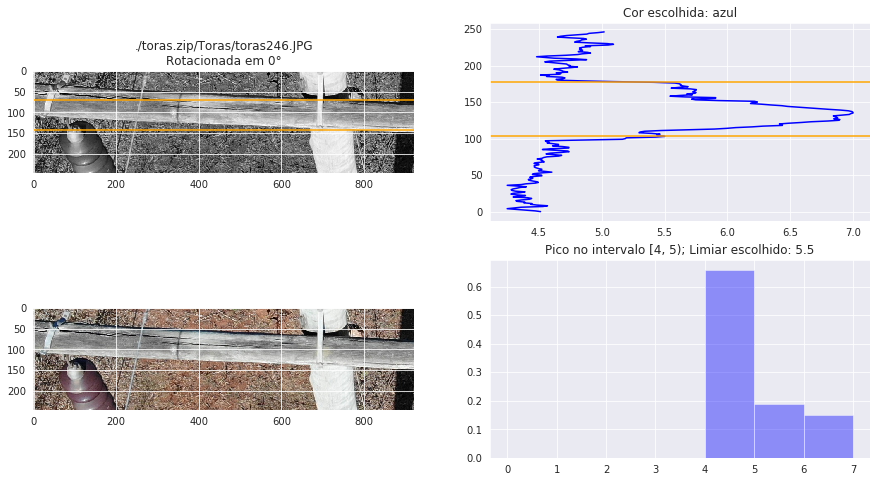

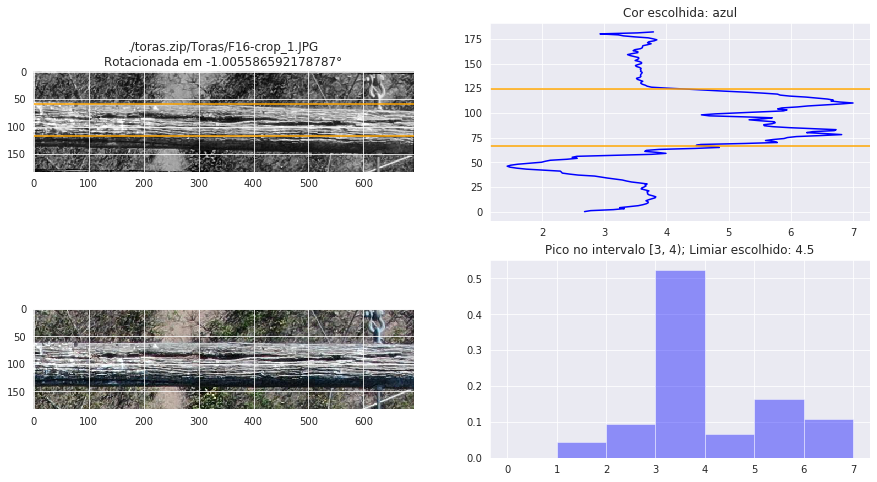

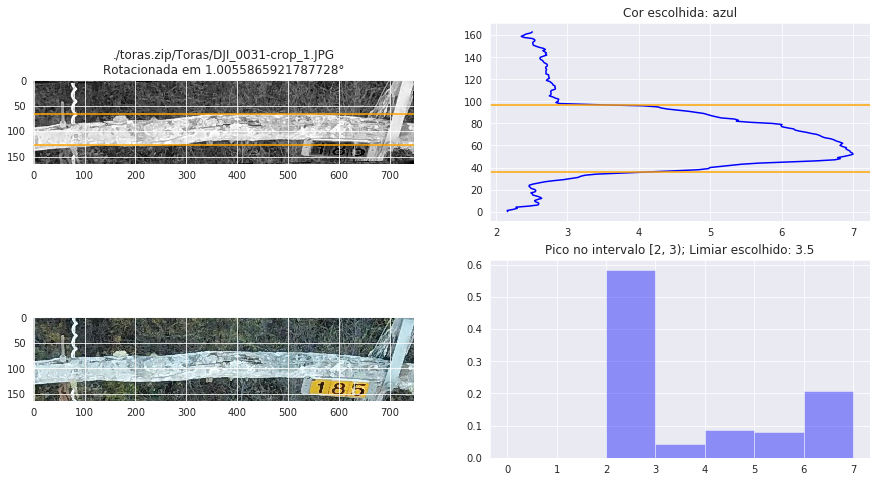

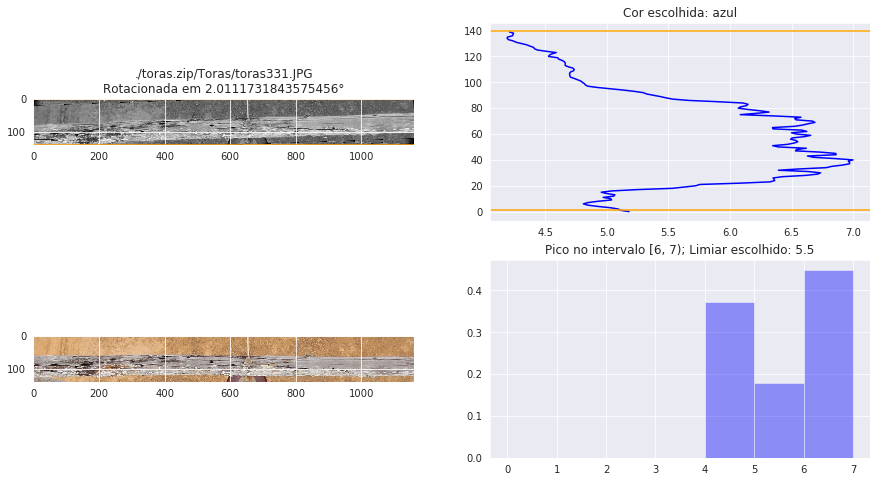

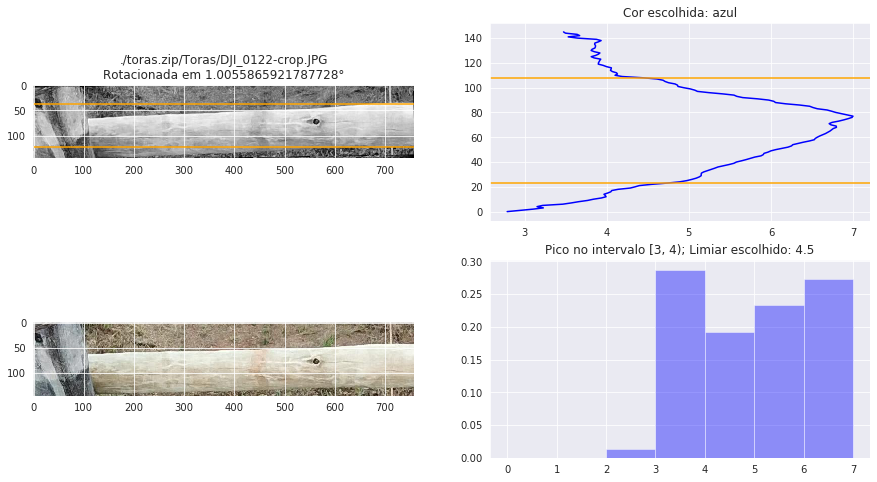

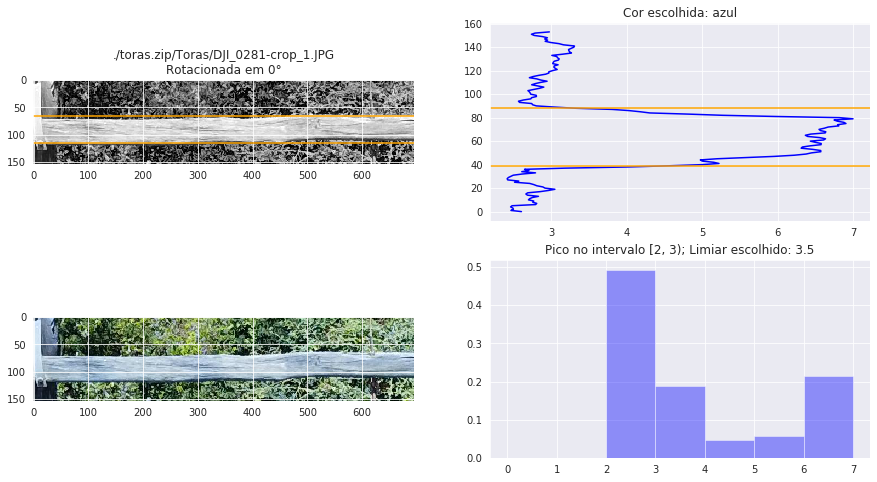

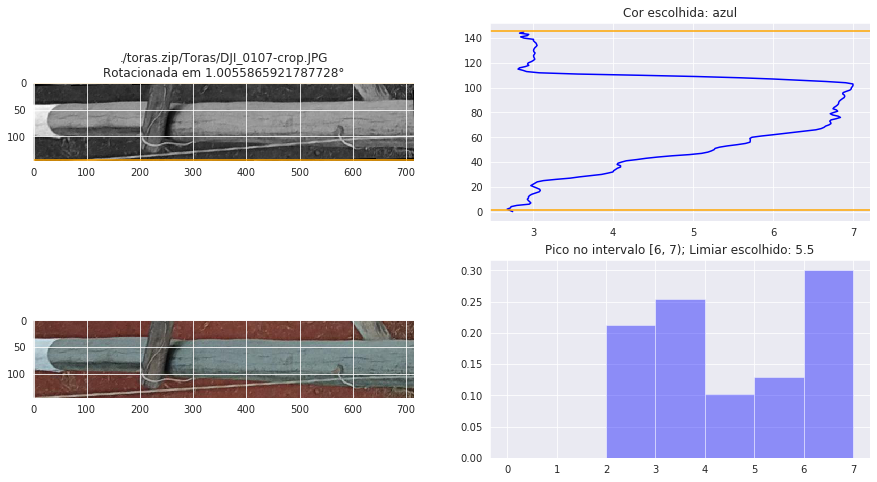

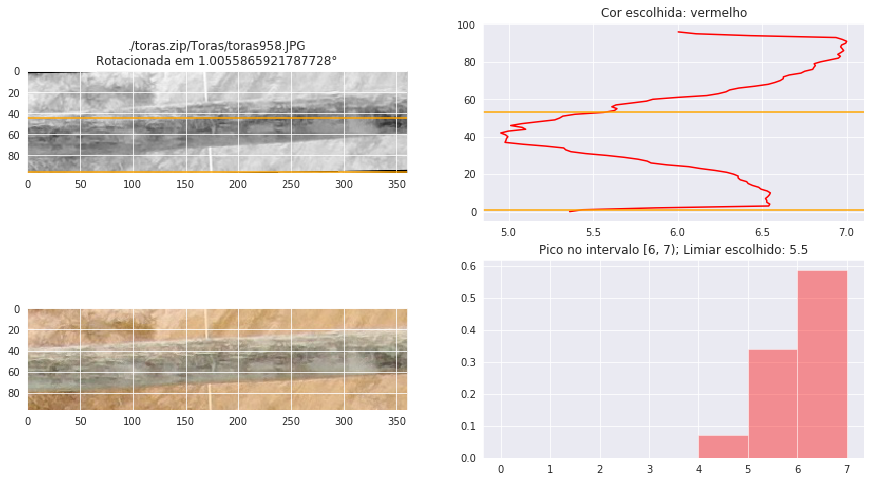

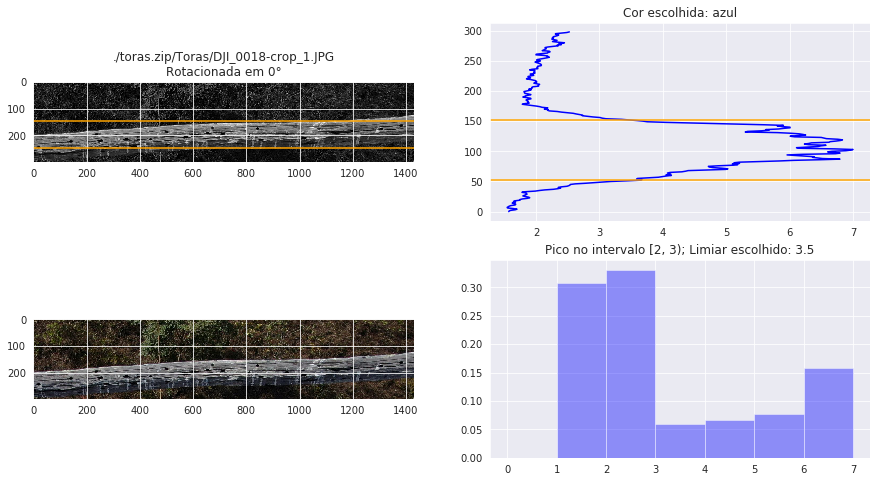

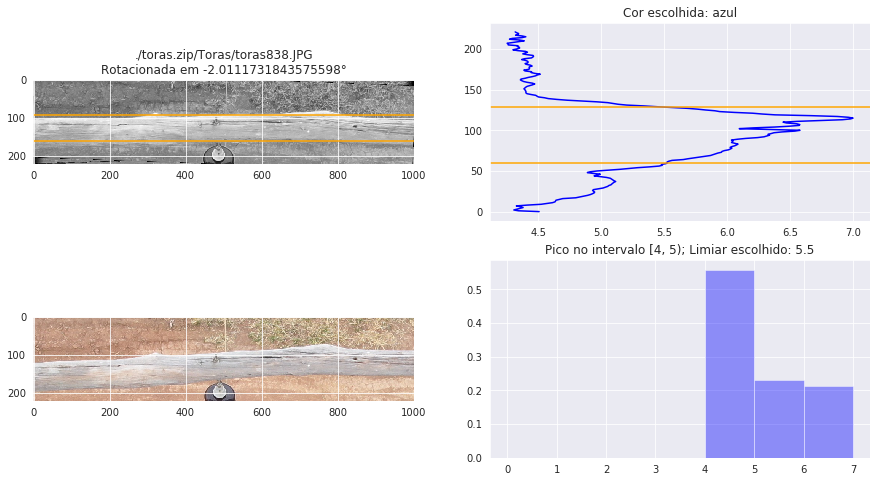

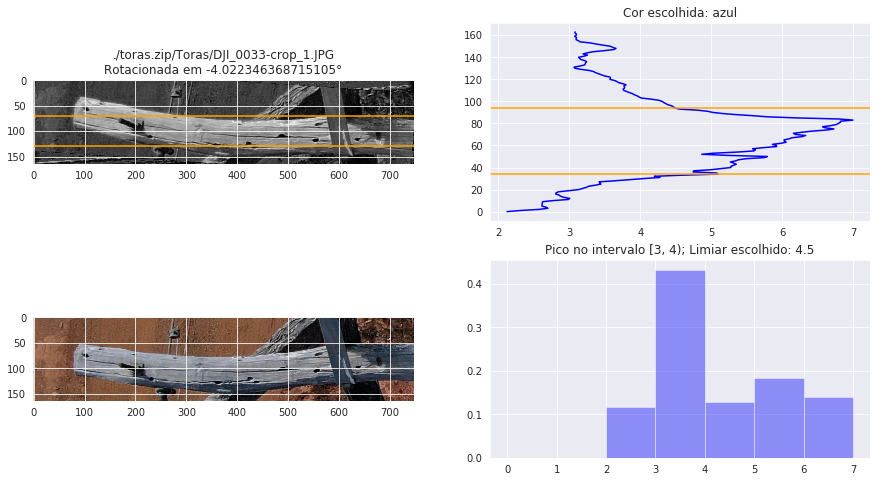

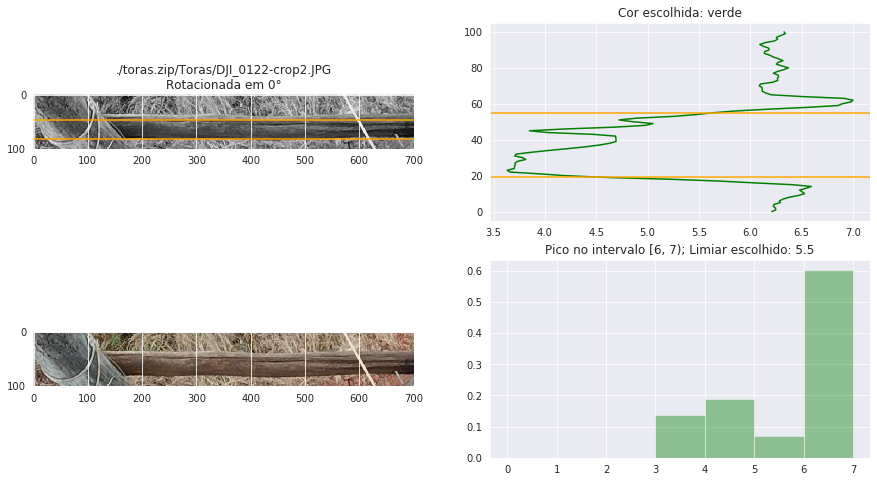

In [3]:
for path in path_list:
  # lendo imagem RGB
  img_gray = imread(path, as_gray=True)
  rot_img, angle = auto_rotate(img_gray)
  
  img = imread(path)
  filled_img = img
  if angle != 0:
    rot_img = rotate(img, angle)
    filled_img = fill_empty_edges(rot_img, metodo=1)

  # Escolhendo qual cor apresenta maior variação
  cor_v, cor_h = best_rgb(filled_img)
  
  # somas verticais e horizontais
  new_img = rgb_to_color(filled_img, cor_h)
  h, w = new_img.shape

  # Plotando imagens
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

  # Plotando imagem original
  ax[1, 0].imshow(img)

  # Exibindo imagem processada da cor selecionada
  ax[0, 0].title.set_text(f'{path}\nRotacionada em {angle}°')
  ax[0, 0].imshow(new_img)
  
  soma_horizontal = new_img.sum(axis=1)
  soma_normalizada = soma_horizontal * (LIMITE_DE_NORMALIZACAO - 1)/soma_horizontal.max()

  # Plotando soma horizontal
  ax[0, 1].title.set_text(f'Cor escolhida: {COLOR_NAMES[cor_h]}')
  ax[0, 1].plot(soma_normalizada,
                range(h-1, -1, -1),
                COLOR_CODES[cor_h])

  hist, bins = np.histogram(soma_normalizada, range(LIMITE_DE_NORMALIZACAO), density=False)
  n = len(hist)
  pos = hist.argmax()
  
  # Somatórios do histograma ao redor do pico
  esquerda = hist[:pos].sum()
  direita = hist[pos+1:].sum()
  if esquerda >= direita:
    limiar = bins[pos] - 0.5
  else:
    limiar = bins[pos+1] + 0.5

  pos_corte = crop_horizontal(new_img, soma_horizontal, return_thresholds=True)
  for p in pos_corte:
    ax[0, 0].axhline(p, color=COLOR_CODES[-1][:-1])   # imagem editada
    ax[0, 1].axhline(h-p, color=COLOR_CODES[-1][:-1]) # soma horizontal

  # Plotando histograma
  ax[1, 1].title.set_text(f'Pico no intervalo [{bins[pos]}, {bins[pos+1]}); Limiar escolhido: {limiar}')
  sns.distplot(
    a=soma_normalizada,
    bins=range(LIMITE_DE_NORMALIZACAO),
    kde=False,
    norm_hist=True,
    ax=ax[1, 1],
    color=COLOR_CODES[cor_h][0])

  plt.show()
